## Demand Projections

### Steel 
1. Estimation of activity data until 2050 while differentiating between the electric arc and the integrated arc

In [280]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from osgeo import ogr

import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression

In [281]:
os.chdir(r"c:\\Users\\flv.eco\\OneDrive - CBS - Copenhagen Business School\\Documents\\01_PtX_Markets\\")

### Input assumptions
#### Electric arc
No hydrogen demand as fully using metal scraps and electricity (Neuwirth(2022) Appendix B) 

#### Integrated Steel
Specific Energy Consumption (SEC) for DRI Steel route is 1.89 MWh/t of produced steel (Neuwirth (2022))   
Müller (2021): For the use of carbon-free CDRI an increase from ε_{el,cs} = 1.76 GJ/tcs (steel scrap processing) to ε_{el,cs} = 2.26 GJ/t_{cs} (DRI processing) can be noticed. 
(Further inquire how the energy demand changes)




Load Data for projection

In [293]:
jrc_region = 'DK'
#['EU27', 'Albania', 'Austria','Belgium', 'Bulgaria', 'Switzerland', 
# 'Cyprus', 'Czechia','Germany', 'Denmark', 'Spain', 'Estonia', 'Finland', 'France','Greece', 'Croatia', 
# 'Hungary', 'Ireland', 'Italy', 'Lithuania','Luxembourg', 'Latvia', 'North Macedonia', 'Malta', 'Montenegro',
# 'Netherlands', 'Norway', 'Poland', 'Portugal', 'Romania', 'Serbia','Slovakia', 'Slovenia', 'Sweden', 'Turkey']
file_name = 'JRC_DATA\JRC-IDEES-2021\\' +jrc_region+ '\JRC-IDEES-2021_Industry_'+jrc_region+'.xlsx'


In [294]:
gdp_region = 'Denmark'
#['European Union - 27 countries (from 2020)', 'Albania', 'Austria','Belgium', 'Bulgaria', 'Switzerland', 
# 'Cyprus', 'Czechia','Germany', 'Denmark', 'Spain', 'Estonia', 'Finland', 'France','Greece', 'Croatia', 
# 'Hungary', 'Ireland', 'Italy', 'Lithuania','Luxembourg', 'Latvia', 'North Macedonia', 'Malta', 'Montenegro',
# 'Netherlands', 'Norway', 'Poland', 'Portugal', 'Romania', 'Serbia','Slovakia', 'Slovenia', 'Sweden', 'Turkey']

gdp = pd.read_excel("Scripts\Projected_GDP.xlsx", index_col="Year")
gdp.index= pd.to_datetime(gdp.index, format='%Y')
gdp = gdp[[gdp_region]]
historic_gdp = gdp[gdp.index < '2022-01-01']
projected_gdp = gdp[gdp.index > '2021-01-01']


In [295]:
steel = pd.read_excel(file_name, sheet_name="ISI")
steel_column_name = jrc_region + ': Iron and steel'

steel.columns = steel.columns.astype(str)  # Ensure all column names are strings
steel_cleaned = steel.loc[:, ~steel.columns.str.contains('^Unnamed:')]
steel_cleaned.dropna(how='any', inplace = True)
steel_cleaned.reset_index(drop=True, inplace=True)

C:\Users\flv.eco\AppData\Local\Temp\ipykernel_6236\663243221.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  steel_cleaned.dropna(how='any', inplace = True)


In [296]:
steel = pd.read_excel(file_name, sheet_name="ISI")
steel_column_name = jrc_region + ': Iron and steel'

In [297]:
steel_bf = pd.DataFrame(steel_cleaned.iloc[2])
steel_bf.columns = steel_bf.iloc[0]
steel_bf.drop([steel_column_name, 'Code'], axis=0, inplace = True)
steel_bf.index.name = 'Year'
steel_bf.index= pd.to_datetime(steel_bf.index, format='%Y')


In [298]:
steel_eaf = pd.DataFrame(steel_cleaned.iloc[3])
steel_eaf.columns = steel_eaf.iloc[0]
steel_eaf.drop([steel_column_name, 'Code'], axis=0, inplace = True)
steel_eaf.index.name = 'Year'
steel_eaf.index= pd.to_datetime(steel_eaf.index, format='%Y')

In [301]:
def linear_regression_single_sector(demand_df, sector_name, historic_gdp, projected_gdp, gdp, region, unit , plot=False, save=False, ):
    """
    Perform linear regression on a single-sector demand dataset and optionally plot/save results.
    
    Parameters:
    - demand_df: DataFrame with Year as index and one column with demand data.
    - sector_name: Name of the sector (string) to label outputs.
    - historic_gdp: DataFrame of historical GDP data (matching time index).
    - projected_gdp: DataFrame of future GDP data (matching time index).
    - gdp: Full GDP data for plotting.
    - region: Name of the region (string) for GDP plotting.
    - plot: Boolean to plot the result.
    - save: Boolean to save the results into Excel.
    
    Returns:
    - results: DataFrame with predicted future demand.
    """

    # Merge demand data with historic GDP
    historical_data = demand_df.join(historic_gdp)

    # Standardize GDP for PCA
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(historic_gdp)

    # Apply PCA
    from sklearn.decomposition import PCA
    pca = PCA(n_components=1)
    principal_components = pca.fit_transform(data_scaled)

    # Add PCA component
    historical_data['PC1'] = principal_components

    # Define target (y) and feature (X)
    y = historical_data[demand_df.columns[0]]  # Demand values
    X = historical_data[['PC1']]                # Principal component

    # Train linear regression model
    model = LinearRegression()
    model.fit(X, y)

    # Predict for the future
    future_data_scaled = scaler.transform(projected_gdp)
    future_pc1 = pca.transform(future_data_scaled)
    y_future = model.predict(future_pc1)
    y_future = np.maximum(y_future, 0)  # No negative demand

    # Prepare result DataFrame
    results = pd.DataFrame({'Predicted Demand': y_future}, index=projected_gdp.index)

    # Plotting
    if plot:
        fig, ax1 = plt.subplots(figsize=(12, 6))
        million_gdp = gdp / 1_000_000
        million_projected_gdp = projected_gdp / 1_000_000

        ax1.plot(demand_df.index, y, label='Historical Demand', color='darkblue')
        ax1.plot(results.index, results['Predicted Demand'], label='Projected Demand (2022-2050)', linestyle='--', color='blue')
        ax1.set_xlabel('Year')
        ax1.set_ylabel('Demand in '+ unit)
        ax1.legend(loc='upper left')

        ax2 = ax1.twinx()
        ax2.plot(million_gdp.index, million_gdp[region], label='GDP', color='green')
        ax2.plot(million_projected_gdp.index, million_projected_gdp[region], label='Projected GDP', linestyle='--', color='lightgreen')
        ax2.set_ylabel('GDP (in million EUR)')
        ax2.legend(loc='upper right')

        plt.title(f'Demand Projection for {sector_name} in {gdp_region}')
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.show()

    # Save
    if save:
        file_path = f"Scripts\\Results\\{datetime.datetime.today().strftime('%Y_%m_%d_')}_{sector_name.replace(' ', '_')}_{region}.xlsx"
        results.to_excel(file_path)

    return results


c:\Users\flv.eco\AppData\Local\anaconda3\envs\ptx_markets\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


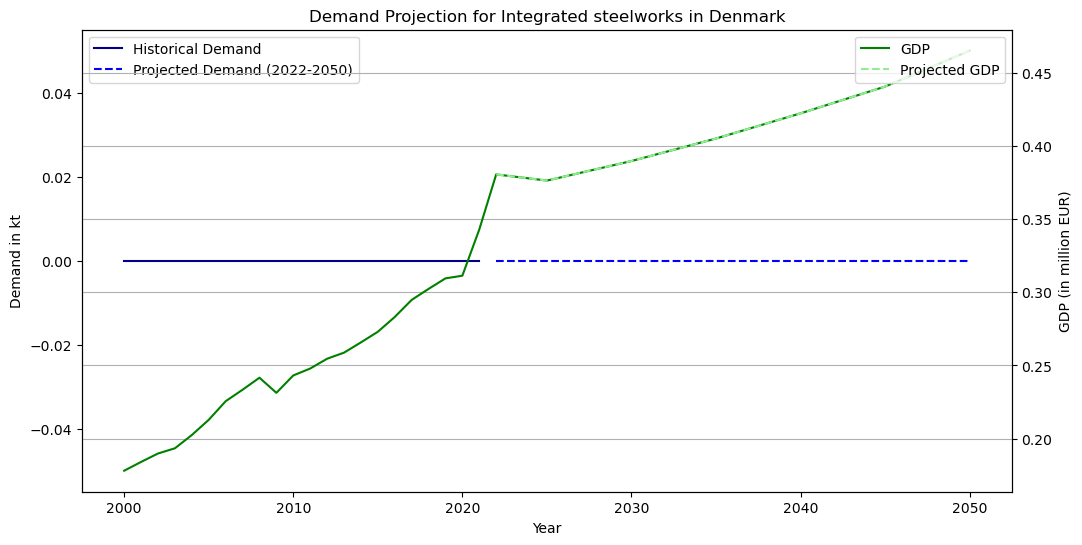

In [302]:
steel_bf_projection = linear_regression_single_sector(demand_df=steel_bf, sector_name = steel_bf.columns[0], historic_gdp=historic_gdp, projected_gdp=projected_gdp, gdp = gdp, region=gdp_region,unit = "kt", plot = True, save = True)

In [303]:
SEC_H2 = 1.89  # Mwh/t_steel
LHV_H2 = 33.3  # t_h2/Mwh 
H2_demand_t__per_t_steel =SEC_H2*LHV_H2

In [304]:
steel_bf_projection["All demand in tH2"] = steel_bf_projection["Predicted Demand"]*H2_demand_t__per_t_steel*1000

In [305]:
def apply_linear_target(demand_df,column_name, targets):
    """
    Linearly interpolate a percentage share over time and apply to demand data.
    
    Parameters:
    - demand_dfs: pd.Datafframe, with datetime-like index, production volume per year.
    - targets: dict, keys are years (as int) and values are target percentages (as float, e.g., 0.1 for 10%).
    
    Returns:
    - pd.Series of adjusted demand based on interpolated shares.
    """
    
    # Create a Series for the target percentages
    target_years = pd.Series(targets)
    target_years.index = pd.to_datetime(target_years.index, format='%Y')
    target_years = target_years.sort_index()

    # Create a full year range between start and end
    full_index = demand_df.index

    # Interpolate linearly
    interpolated_share = target_years.reindex(full_index).interpolate(method='time').fillna(method='ffill').fillna(0)

    # Apply the interpolated share to the demand
    demand_df["Demand in tH2"] = demand_df[column_name] * interpolated_share

    return demand_df


In [306]:
targets = {
    2020: 0.00,
    2030: 0.10,
    2040: 0.40,
    2050: 1.00
}
steel_bf_projection = apply_linear_target(steel_bf_projection, "All demand in tH2", targets)

C:\Users\flv.eco\AppData\Local\Temp\ipykernel_6236\2442886372.py:22: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  interpolated_share = target_years.reindex(full_index).interpolate(method='time').fillna(method='ffill').fillna(0)


In [307]:
steel_bf_projection

,Predicted Demand,All demand in tH2,Demand in tH2
Year,,,
2022-01-01,0.0,0.0,0.0
2023-01-01,0.0,0.0,0.0
2024-01-01,0.0,0.0,0.0
2025-01-01,0.0,0.0,0.0
2026-01-01,0.0,0.0,0.0
2027-01-01,0.0,0.0,0.0
2028-01-01,0.0,0.0,0.0
2029-01-01,0.0,0.0,0.0
2030-01-01,0.0,0.0,0.0


### Chemicals
Production for primary Steel, Methanol, Ammonia and Ethylene are factory specific estimated in Neuwirth et al (2024). 
Overall production for basic chemcials are calculated in JRC data in kt ethylene eq. 

The share of ammonia, methanol and ethylene and remaining is estimated based on the data from Neuwirth et al (2024). For this for the production must be converted from t of methanol/ammonia to t of ethylene eq. using SEC [GJ/tonne of output] data from Saygin et al (2011) 
| Country  | SEC_Meth | SEC_Amm | SEC_HVC |
|----------|----------|---------|---------|
| Benelux  | 10       | 14.3    | 15.3    |
| FR       |          | 16.5    | 15.4    |
| DE       | 12.4     | 16.6    | 15.7    |
| IT       |          | 15      | 15.9    |
| Average  | 11.2     | 15.6    | 15.575  |



Once this is done the share in each country can be calculated. Then the conversion to hydrogen processes can be estimated by Neuwirth 2022. Methanol consumption based on data in appendix B.2. Chemical Industry
| Product  | Feedstock | Unit |
|----------|-----------|------|
| Methanol | 6.31      | MWh/tH2    | 
| Ammonia  | 5.92      | MWh/tH2    |
| Ethylene | 2.54      | MWh/t_MeOH |

In [308]:
chemicals = pd.read_excel(file_name, sheet_name="CHI")
chemicals_column_name = jrc_region + ': Chemical industry'
chemicals.columns = chemicals.columns.astype(str)  # Ensure all column names are strings
chemicals_cleaned = chemicals.loc[:, ~chemicals.columns.str.contains('^Unnamed:')]
chemicals_cleaned.dropna(how='any', inplace = True)
chemicals_cleaned.reset_index(drop=True, inplace=True)


C:\Users\flv.eco\AppData\Local\Temp\ipykernel_6236\3167198536.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chemicals_cleaned.dropna(how='any', inplace = True)


In [309]:
basic_chem = pd.DataFrame(chemicals_cleaned.iloc[3])
basic_chem.columns = basic_chem.iloc[0]
basic_chem.drop([chemicals_column_name, 'Code'], axis=0, inplace = True)
basic_chem.index.name = 'Year'
basic_chem.index= pd.to_datetime(basic_chem.index, format='%Y')

c:\Users\flv.eco\AppData\Local\anaconda3\envs\ptx_markets\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


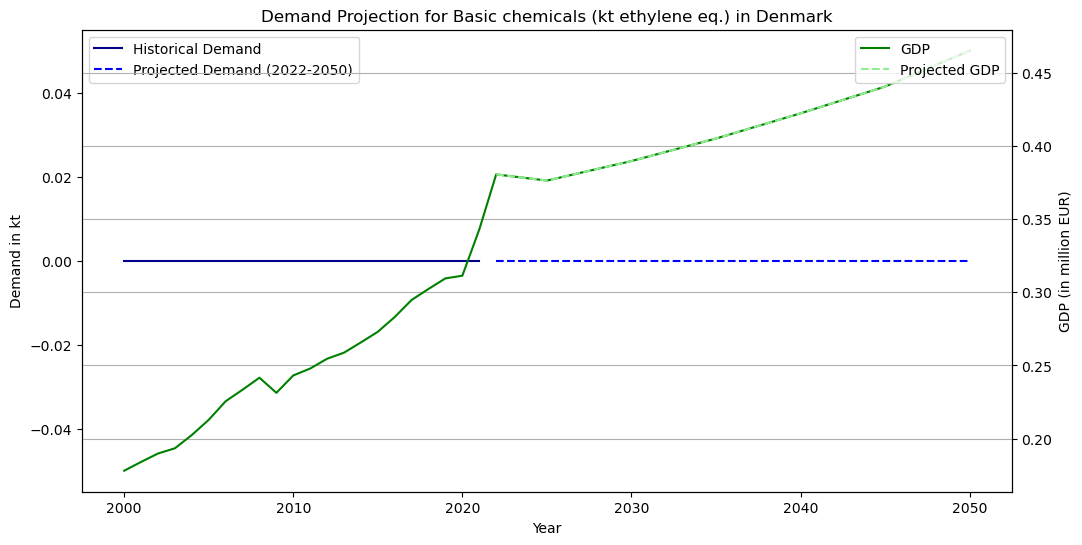

In [310]:
basic_chem_projection = linear_regression_single_sector(demand_df=basic_chem, sector_name = basic_chem.columns[0], historic_gdp=historic_gdp, projected_gdp=projected_gdp, gdp = gdp, region=gdp_region,unit = "kt", plot = True, save = False)

In [311]:
production_Neuwirth_2024 = pd.read_excel("Industry_Data/Neuwirth_2024_Supplementary_Data/02_Industrial_Site_Database.xlsx", sheet_name="Database")

In [312]:
# in GJ/t
SEC_MeOH_Benelux = 10 
SEC_MeOH_DE = 12.4
SEC_MeOH_Average = 11.2

SEC_NH3_Benelux = 14.3
SEC_NH3_FR = 16.5
SEC_NH3_DE = 16.6
SEC_NH3_IT = 15 
SEC_NH3_Average = 15.6

SEC_HVC_Benelux = 15.3 
SEC_HVC_FR = 15.4
SEC_HVC_DE = 15.7
SEC_HVC_IT = 15.9
SEC_HVC_Average = 15.575 

# In GWh/t 
SEC_HVC_Benelux_GWh = SEC_HVC_Benelux/3600
SEC_HVC_FR_GWh = SEC_HVC_FR/3600
SEC_HVC_DE_GWh = SEC_HVC_DE/3600
SEC_HVC_IT_GWh = SEC_HVC_IT/3600
SEC_HVC_Average_GWh = SEC_HVC_Average/3600





In [313]:
# Conversion to get the ethylene eq for methanol and ammonia
MeOH_to_HVC = SEC_MeOH_Average/SEC_HVC_Average 
NH3_to_HVC = SEC_NH3_Average/SEC_HVC_Average

# Methanol demand for producing ethylene
HVC_to_MeOH = 2.54

In [314]:
steel_Neuwirth_2024 = production_Neuwirth_2024.query("Product == 'Steel, primary'")
HVC_Neuwirth_2024 = production_Neuwirth_2024.query("Product == 'Ethylene'")
MeOH_Neuwirth_2024 = production_Neuwirth_2024.query("Product == 'Methanol'")
NH3_Neuwirth_2024 = production_Neuwirth_2024.query("Product == 'Ammonia'")

In [315]:
steel_Neuwirth_2024_SUM = steel_Neuwirth_2024["Production in tons (calibrated)"].sum()
HVC_Neuwirth_2024_SUM = HVC_Neuwirth_2024["Production in tons (calibrated)"].sum()
MeOH_Neuwirth_2024_SUM = MeOH_Neuwirth_2024["Production in tons (calibrated)"].sum()
NH3_Neuwirth_2024_SUM = NH3_Neuwirth_2024["Production in tons (calibrated)"].sum()

In [316]:
HVC_Neuwirth_2024_SUM/1000

18860.410514370004

#### JRC on Chemical sector
![JRC Chemicals](../Industry_Data/JRC_Chemicals.png)

#### Chemicals in Neuwirth 2024 and JRC 2022 (estimated), last year of data 2021
Neuwirth estimates to 34,145 kt ethylene eq  
JRC overall chemical sector 86,747 kt ethylene eq , however this includes several other forms of chemcials. Therefore a percentage is taken of the current situation and this is projected with the JRC data.
then the shares are converted from ethylene equivalents to methanol or ammonia demand 


In [317]:
# Get ethylene eq to compare
MeOH_Neuwirth_2024_SUM_ethylene_eq = MeOH_Neuwirth_2024_SUM*MeOH_to_HVC
NH3_Neuwirth_2024_SUM_ethylene_eq = NH3_Neuwirth_2024_SUM*NH3_to_HVC

In [318]:
Neuwirth_chemicals_SUM = HVC_Neuwirth_2024_SUM + MeOH_Neuwirth_2024_SUM_ethylene_eq + NH3_Neuwirth_2024_SUM_ethylene_eq

In [319]:
# from t ethylene eq to kt ethylene eq
Neuwirth_chemicals_SUM/1000 

34145.49946406631

In [320]:
basic_chem_projection.query("Year == @pd.Timestamp('2022-01-01')")["Predicted Demand"][0]

C:\Users\flv.eco\AppData\Local\Temp\ipykernel_6236\1768171749.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  basic_chem_projection.query("Year == @pd.Timestamp('2022-01-01')")["Predicted Demand"][0]


0.0

In [321]:
share_MeOH= (MeOH_Neuwirth_2024_SUM_ethylene_eq/1000)/(basic_chem_projection.query("Year == @pd.Timestamp('2022-01-01')")["Predicted Demand"][0])
share_NH3 = (NH3_Neuwirth_2024_SUM_ethylene_eq/1000)/(basic_chem_projection.query("Year == @pd.Timestamp('2022-01-01')")["Predicted Demand"][0])
share_ethylene =(HVC_Neuwirth_2024_SUM/1000)/(basic_chem_projection.query("Year == @pd.Timestamp('2022-01-01')")["Predicted Demand"][0])

C:\Users\flv.eco\AppData\Local\Temp\ipykernel_6236\1892571964.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  share_MeOH= (MeOH_Neuwirth_2024_SUM_ethylene_eq/1000)/(basic_chem_projection.query("Year == @pd.Timestamp('2022-01-01')")["Predicted Demand"][0])
C:\Users\flv.eco\AppData\Local\Temp\ipykernel_6236\1892571964.py:1: RuntimeWarning: divide by zero encountered in scalar divide
  share_MeOH= (MeOH_Neuwirth_2024_SUM_ethylene_eq/1000)/(basic_chem_projection.query("Year == @pd.Timestamp('2022-01-01')")["Predicted Demand"][0])
C:\Users\flv.eco\AppData\Local\Temp\ipykernel_6236\1892571964.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by positi

In [322]:
basic_chem_projection["MeOH Demand [kt ethylene eq]"] = (basic_chem_projection["Predicted Demand"]*share_MeOH)
basic_chem_projection["NH3 Demand [kt ethylene eq]"] = (basic_chem_projection["Predicted Demand"]*share_NH3)
basic_chem_projection["HVC Demand [kt ethylene eq]"] = basic_chem_projection["Predicted Demand"]*share_ethylene


In [323]:
basic_chem_projection["MeOH Demand [kt MeOH]"] = (basic_chem_projection["MeOH Demand [kt ethylene eq]"])/MeOH_to_HVC
basic_chem_projection["NH3 Demand [kt NH3]"] = (basic_chem_projection["NH3 Demand [kt ethylene eq]"])/NH3_to_HVC
basic_chem_projection["HVC Demand [kt MeOH]"] = basic_chem_projection["HVC Demand [kt ethylene eq]"]*SEC_HVC_Average_GWh*HVC_to_MeOH


In [324]:
SEC_HVC_Average_GWh*HVC_to_MeOH*18860.410514

207.257575038638

In [325]:
basic_chem_projection

,Predicted Demand,MeOH Demand [kt ethylene eq],NH3 Demand [kt ethylene eq],HVC Demand [kt ethylene eq],MeOH Demand [kt MeOH],NH3 Demand [kt NH3],HVC Demand [kt MeOH]
Year,,,,,,,
2022-01-01,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-01,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2024-01-01,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2025-01-01,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2026-01-01,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2027-01-01,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2028-01-01,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2029-01-01,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2030-01-01,0.0,NaN,NaN,NaN,NaN,NaN,NaN


##### Validation Comparison Neuwirth data and JRC
More capacity estimated in Neuwirth [84,963 kt] Steel capacity compared to JRC Steel production [79,155 kt] in Europe

In [326]:
steel_Neuwirth_2024_SUM/1000

84963.23024100001

In [337]:
steel_bf_projection["Predicted Demand"][0]

C:\Users\flv.eco\AppData\Local\Temp\ipykernel_6236\1448053946.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  steel_bf_projection["Predicted Demand"][0]


0.0

#### Melting and Casting of Iron and Steel, Aluminium production, NE Metals
UBA: TRL 9 of electrification therefore full electrification considered




#### Steam Production  
Electrical alternative have a TRL of 9 where several alternative are available such as the electrode boiler, heat pump systems etc. 

#### Metal processsesing in Macherinery and transport equipement  
Mainly eletric, rest could be green fuels but relatively small


#### Cement

Green fuel demand only in preheating and clinker production. Currently, 67% using already alternative heating sources such as different forms of waste.  
The TRL of the alternative production routes is fairly low with levels of <3 for a full electrification, <4 for hydrogen heating systems. Alternative options are hybrid versions discussed, the TRL levels remain low.  
Workaround: 
1. Replacing fossil fuel in the process of clinker production and Preheating and pre calcination process which is specifically distingished in JRC data set
2. Assuming waste as input
3. Increase waste share according to regression analysis, remaining share is taken from hydrogen/electricity 

##### Cement Biomass Content
1. Clean Data read from excel file
2. Get relevant data from fuel demand 
3. Get Percentage for biomass content
4. Match with overall fuel consumption (Forecast)

In [338]:
NMM_column_name = jrc_region+ ': Non-metallic mineral products / final energy consumption'


In [339]:
def transpose_uniformly(df):
    df_T = df.transpose()
    df_T.columns = df_T.iloc[0]
    df_T.drop([NMM_column_name, "Code"], axis=0, inplace = True)
    df_T.index.name = 'Year'
    df_T.index= pd.to_datetime(df_T.index, format='%Y')
    return(df_T)

In [340]:
def linear_regression_with_prediction(demand_sector_df, future_data_df, column_name_LR, column_name_IV, column_name_IV_future,  graph_title, save=False):
    """
    Perform a simple linear regression on historical data, visualize results, and predict future values.
    
    Parameters:
    - demand_sector_df: DataFrame containing historical demand data.
    - future_data_df: DataFrame containing future values of the independent variable for prediction.
    - column_name_LR: Name of the column in demand_sector_df to be used as the target variable (y).
    - column_name_IV: Name of the column in demand_sector_df and future_data_df to be used as the independent variable (X).
    - save: Boolean indicating whether to save the results to an Excel file.
    
    Returns:
    - A DataFrame containing historical and future predictions.
    """

    # Define the target (y) and feature (X) for historical data
    y = demand_sector_df[column_name_LR]  # Convert y to a Series
    X = demand_sector_df[[column_name_IV]]  # Independent variable (e.g., GDP)

    # Drop NaN values to avoid regression errors
    X = X.dropna()
    y = y.loc[X.index]

    # Train the linear regression model
    model = LinearRegression()
    model.fit(X, y)

    # Predict historical values
    y_pred = model.predict(X)

    # Combine predictions and actual values into a results DataFrame
    results_historical = pd.DataFrame({
        'Actual Percentage': y,
        'Predicted Percentage': y_pred
    }, index=X.index)

    # Prepare future data for prediction
    future_data_df = future_data_df.rename(columns={column_name_IV_future: column_name_IV})
    X_future = future_data_df[[column_name_IV]].dropna()  # Independent variable for future data
    y_future_pred = model.predict(X_future)

    # Combine future predictions into a results DataFrame
    results_future = pd.DataFrame({
        'Predicted Percentage': y_future_pred
    }, index=X_future.index)

    # Combine historical and future results
    combined_results = pd.concat([results_historical[['Predicted Percentage']], results_future], axis=0)

    # Plot historical actual vs. predicted values and future predictions
    plt.figure(figsize=(10, 6))
    plt.plot(results_historical.index, results_historical['Actual Percentage'], label='Actual Percentage (Historical)', color='blue')
    plt.plot(results_historical.index, results_historical['Predicted Percentage'], label='Predicted Percentage (Historical)', color='orange', linestyle='--')
    plt.plot(results_future.index, results_future['Predicted Percentage'], label='Predicted Percentage (Future)', color='green', linestyle='--')
    plt.xlabel('Year')
    plt.ylabel(f'{column_name_LR}')
    plt.title(graph_title)
    plt.legend()
    plt.grid(True)
    plt.show()

    # Save results to Excel if requested
    if save:
        combined_results.to_excel(f"results_{column_name_LR}_demand_with_predictions.xlsx")
    
    return combined_results


In [341]:
NMM = pd.read_excel(file_name, sheet_name="NMM_fec")
NMM.columns = NMM.columns.astype(str)  # Ensure all column names are strings
NMM_cleaned = NMM.loc[:, ~NMM.columns.str.contains('^Unnamed:')]
NMM_cleaned.dropna(how='any', inplace = True)
NMM_cleaned.reset_index(drop=True, inplace=True)


C:\Users\flv.eco\AppData\Local\Temp\ipykernel_6236\3130932235.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  NMM_cleaned.dropna(how='any', inplace = True)


In [342]:
cement = NMM_cleaned.iloc[:(NMM_cleaned[NMM_cleaned[NMM_column_name] == "Ceramics & other NMM"].index[0])]
ceramics = NMM_cleaned.iloc[(NMM_cleaned[NMM_cleaned[NMM_column_name] == "Ceramics & other NMM"].index[0]):(NMM_cleaned[NMM_cleaned[NMM_column_name] == "Glass production"].index[0])]
glass = NMM_cleaned.iloc[(NMM_cleaned[NMM_cleaned[NMM_column_name] == "Glass production"].index[0]):(NMM_cleaned[NMM_cleaned[NMM_column_name] == "Glass: Finishing processes"].index[0]+1)]

In [343]:
cement_preheating = cement.iloc[(cement[cement[NMM_column_name] == "Cement: Pre-heating and pre-calcination"].index[0]):(cement[cement[NMM_column_name] == "Cement: Clinker production (kilns)"].index[0])]
cement_clinker = cement.iloc[(cement[cement[NMM_column_name] == "Cement: Clinker production (kilns)"].index[0]):(cement[cement[NMM_column_name] == "Cement: Grinding, packaging and precasting (electricity)"].index[0])]

In [344]:
historic_cement_demand_ktoe = NMM_cleaned.iloc[(NMM_cleaned[NMM_cleaned[NMM_column_name] == "Cement"].index[0])]

In [345]:
historic_cement_demand_ktoe = transpose_uniformly(historic_cement_demand_ktoe)
historic_cement_demand_ktoe = historic_cement_demand_ktoe.to_frame()
historic_cement_demand_ktoe.columns=["Cement"]

C:\Users\flv.eco\AppData\Local\Temp\ipykernel_6236\2364290554.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_T.drop([NMM_column_name, "Code"], axis=0, inplace = True)


In [346]:
cement_clinker = transpose_uniformly(cement_clinker)
cement_preheating = transpose_uniformly(cement_preheating)

In [347]:
cement_preheating

DK: Non-metallic mineral products / final energy consumption,Cement: Pre-heating and pre-calcination,Solids,LPG,Diesel oil and liquid biofuels,Fuel oil,Other liquids,Natural gas and biogas,Biomass and waste
Year,,,,,,,,
2000-01-01,22.820804,6.470229,0.554136,0.743287,1.092379,8.961039,4.985226,0.014509
2001-01-01,25.713871,5.871369,0.371656,0.89594,0.903188,11.675004,5.254263,0.742451
2002-01-01,24.31611,5.094014,0.371773,0.811588,0.985606,11.603474,4.825777,0.623878
2003-01-01,24.061192,5.456324,0.389308,0.91373,0.649832,11.07606,4.502374,1.073565
2004-01-01,26.956254,6.480061,0.412565,1.009852,0.769674,12.227751,4.599306,1.457044
2005-01-01,23.768234,5.791888,0.418799,1.000228,0.592145,10.628628,3.995906,1.340642
2006-01-01,31.99524,8.132682,0.538473,1.188156,1.427536,14.197583,5.477082,1.033729
2007-01-01,30.31049,7.287628,0.287835,0.882117,1.314183,13.986923,5.320286,1.231518
2008-01-01,28.890085,5.803517,0.240463,0.775836,0.58077,13.319201,5.366003,2.804293


In [348]:
historic_cement_demand_ktoe["Biomass and waste fuel share"] = (cement_clinker["Biomass and waste"]+cement_preheating["Biomass and waste"])/historic_cement_demand_ktoe["Cement"]

historic_cement_demand_ktoe["Remainder fuel share"] = ((cement_clinker["Cement: Clinker production (kilns)"]-cement_clinker["Biomass and waste"])+(cement_preheating["Cement: Pre-heating and pre-calcination"]-cement_preheating["Biomass and waste"]))/historic_cement_demand_ktoe["Cement"]

#cement_clinker_T["Biomass and waste percentage"] = cement_clinker_T["Biomass and waste"]/cement_clinker_T["Cement: Clinker production (kilns)"]
#cement_clinker_T["NG percentage"] = cement_clinker_T["Natural gas and biogas"]/cement_clinker_T["Cement: Clinker production (kilns)"]


c:\Users\flv.eco\AppData\Local\anaconda3\envs\ptx_markets\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


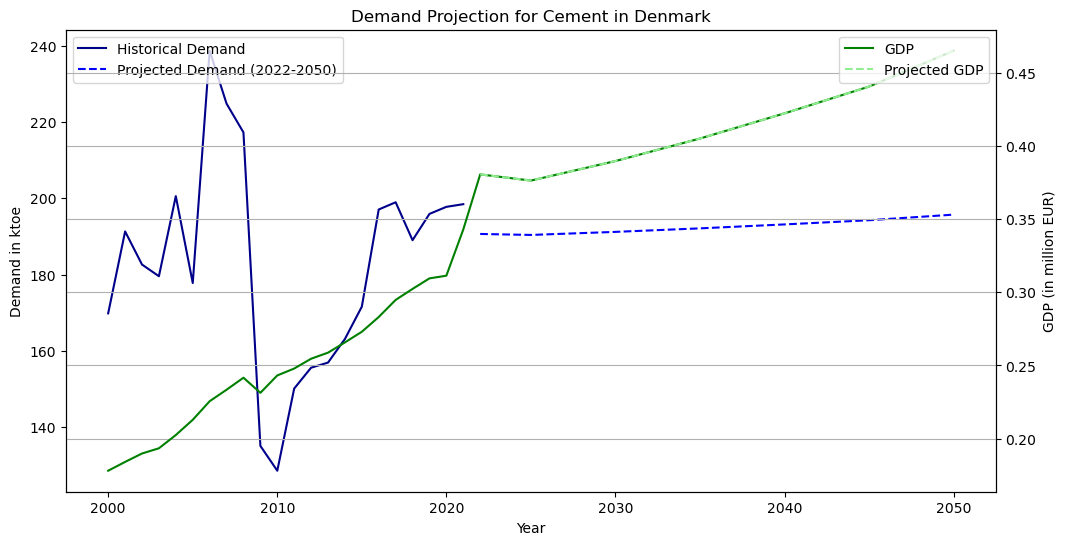

In [349]:
cement_projection = linear_regression_single_sector(demand_df=historic_cement_demand_ktoe, sector_name = historic_cement_demand_ktoe.columns[0], historic_gdp=historic_gdp, projected_gdp=projected_gdp, gdp = gdp, region=gdp_region,unit = "ktoe", plot = True, save = False)

In [350]:
ktoe_to_GWh = 11.63
cement_projection.rename(columns={'Predicted Demand': 'Predicted Demand [ktoe]'}, inplace=True)
cement_projection["Predicted Demand [GWh]"] = cement_projection["Predicted Demand [ktoe]"]*ktoe_to_GWh

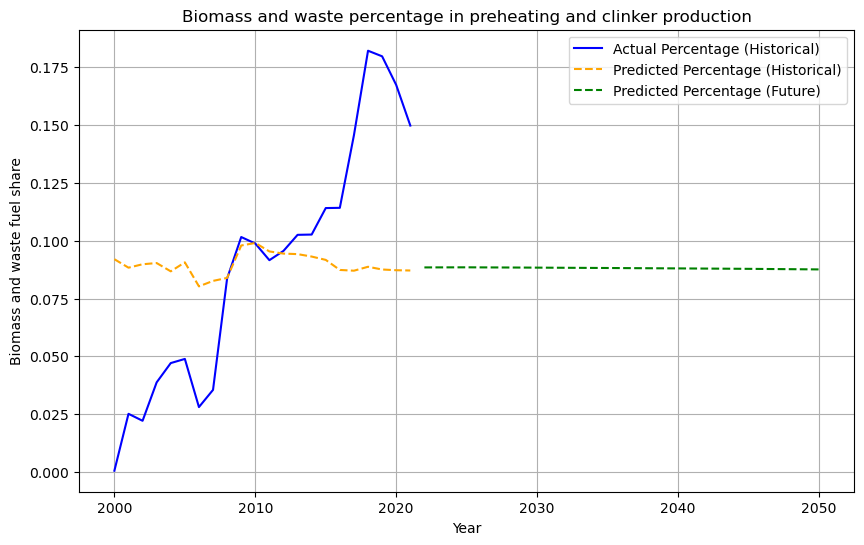

In [351]:
cement_projection_biomass_percentage= linear_regression_with_prediction(demand_sector_df=historic_cement_demand_ktoe,future_data_df=cement_projection, column_name_LR="Biomass and waste fuel share", column_name_IV="Cement",column_name_IV_future= "Predicted Demand [ktoe]", graph_title = "Biomass and waste percentage in preheating and clinker production", save = False)


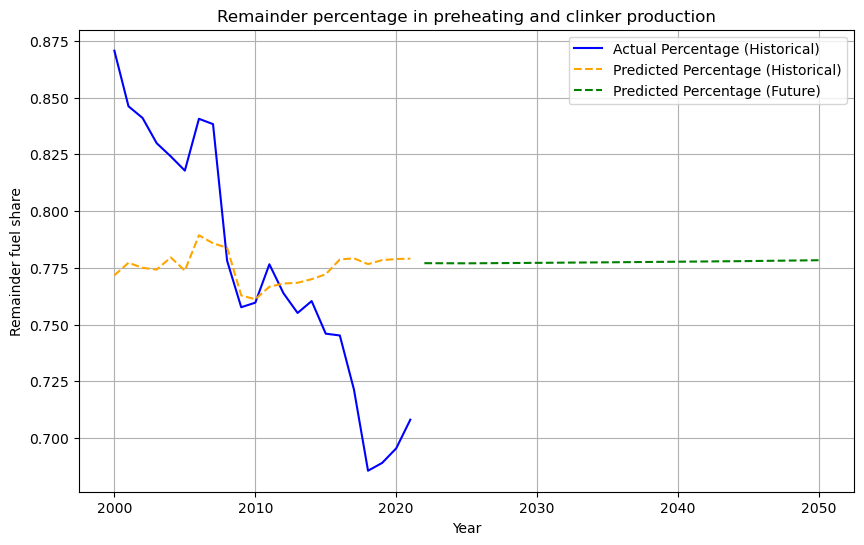

In [352]:
cement_projection_NG_H2_percentage = linear_regression_with_prediction(demand_sector_df=historic_cement_demand_ktoe,future_data_df=cement_projection, column_name_LR="Remainder fuel share", column_name_IV="Cement",column_name_IV_future= "Predicted Demand [ktoe]", graph_title = "Remainder percentage in preheating and clinker production", save = False)

In [353]:
cement_projection_biomass_percentage.rename(columns={'Predicted Percentage': 'Predicted Biomass Percentage'}, inplace=True)
cement_projection_NG_H2_percentage.rename(columns={'Predicted Percentage': 'Predicted NG/H2 Percentage'}, inplace=True)


In [354]:
cement_projection["Predicted Biomass Demand [GWh]"] = cement_projection["Predicted Demand [GWh]"]*cement_projection_biomass_percentage["Predicted Biomass Percentage"]
cement_projection["Predicted Remainder Demand [GWh]"] = cement_projection["Predicted Demand [GWh]"]*cement_projection_NG_H2_percentage["Predicted NG/H2 Percentage"]


In [355]:
cement_projection

,Predicted Demand [ktoe],Predicted Demand [GWh],Predicted Biomass Demand [GWh],Predicted Remainder Demand [GWh]
Year,,,,
2022-01-01,190.649704,2217.256057,196.112811,1722.931865
2023-01-01,190.565068,2216.271739,196.057694,1722.119035
2024-01-01,190.480432,2215.287420,196.002549,1721.306248
2025-01-01,190.395796,2214.303102,195.947376,1720.493504
2026-01-01,190.556218,2216.168813,196.051929,1722.034044
2027-01-01,190.716640,2218.034524,196.156381,1723.574737
2028-01-01,190.877062,2219.900235,196.260730,1725.115582
2029-01-01,191.037485,2221.765946,196.364978,1726.656581
2030-01-01,191.197907,2223.631657,196.469123,1728.197733


In [356]:
cement_projection_biomass_percentage["Predicted Biomass Percentage"]+cement_projection_NG_H2_percentage["Predicted NG/H2 Percentage"]

Year
2000-01-01    0.863725
2001-01-01    0.865561
2002-01-01    0.864819
2003-01-01    0.864557
2004-01-01    0.866352
2005-01-01    0.864405
2006-01-01    0.869611
2007-01-01    0.868425
2008-01-01    0.867781
2009-01-01    0.860755
2010-01-01    0.860198
2011-01-01    0.862040
2012-01-01    0.862507
2013-01-01    0.862622
2014-01-01    0.863151
2015-01-01    0.863874
2016-01-01    0.866052
2017-01-01    0.866215
2018-01-01    0.865365
2019-01-01    0.865954
2020-01-01    0.866112
2021-01-01    0.866172
2022-01-01    0.865504
2023-01-01    0.865497
2024-01-01    0.865490
2025-01-01    0.865483
2026-01-01    0.865496
2027-01-01    0.865510
2028-01-01    0.865524
2029-01-01    0.865537
2030-01-01    0.865551
2031-01-01    0.865567
2032-01-01    0.865583
2033-01-01    0.865598
2034-01-01    0.865614
2035-01-01    0.865630
2036-01-01    0.865648
2037-01-01    0.865665
2038-01-01    0.865683
2039-01-01    0.865701
2040-01-01    0.865718
2041-01-01    0.865737
2042-01-01    0.865756
2043-0

#### Ceramics
Switch from NG to electrical heating requires new oven design and high investment cost, TRL<4
Switch from NG to hydrogen technically possible within the existing plant design. However, no industrial application so far, TRL <5

Workaround: 
1. Substituting fossil fuels  in the process
2. Assuming SNG/Hydrogen as a replacement

In the process of thermal drying and sintering, and in the production - majority is provided by SNG/H2/etc.   
In the primary production the biomass share is increase according to linear regression. 


In [357]:
historic_ceramics_demand_ktoe = NMM_cleaned.iloc[(NMM_cleaned[NMM_cleaned[NMM_column_name] == "Ceramics & other NMM"].index[0])]

In [358]:
historic_ceramics_demand_ktoe = transpose_uniformly(historic_ceramics_demand_ktoe)
historic_ceramics_demand_ktoe = historic_ceramics_demand_ktoe.to_frame()
historic_ceramics_demand_ktoe.columns=["Ceramics"]

C:\Users\flv.eco\AppData\Local\Temp\ipykernel_6236\2364290554.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_T.drop([NMM_column_name, "Code"], axis=0, inplace = True)


In [359]:
ceramics_sintering = ceramics.loc[(ceramics[ceramics[NMM_column_name] == "Ceramics: Thermal drying and sintering"].index[0]):(ceramics[ceramics[NMM_column_name] == "Ceramics: Microwave drying and sintering"].index[0]-1)]
ceramics_production = ceramics.loc[(ceramics[ceramics[NMM_column_name] == "Ceramics: Thermal kiln"].index[0]):(ceramics[ceramics[NMM_column_name] == "Ceramics: Electric kiln"].index[0])]

In [360]:
ceramics_sintering = transpose_uniformly(ceramics_sintering)
ceramics_production = transpose_uniformly(ceramics_production)

In [361]:
ceramics_sintering["Ceramics: Drying and sintering of raw material"] = ceramics_sintering["Ceramics: Thermal drying and sintering"]+ceramics_sintering["Ceramics: Steam drying and sintering"]
ceramics_production["Ceramics: Primary production process"] = ceramics_production["Ceramics: Thermal kiln"]+ceramics_production["Ceramics: Electric kiln"]

In [362]:
ceramics_production

DK: Non-metallic mineral products / final energy consumption,Ceramics: Thermal kiln,Solids,LPG,Diesel oil and liquid biofuels,Fuel oil,Other liquids,Natural gas and biogas,Biomass and waste,Ceramics: Electric kiln,Ceramics: Primary production process
Year,,,,,,,,,,
2000-01-01,254.810701,72.244769,6.187322,8.299335,12.197194,100.056445,55.663633,0.162003,13.869766,268.680467
2001-01-01,234.737855,53.598797,3.39279,8.178892,8.245062,106.57926,47.965333,6.777722,12.753873,247.491729
2002-01-01,221.135106,46.325883,3.380974,7.380725,8.963276,105.524092,43.886493,5.673663,13.268303,234.40341
2003-01-01,246.093291,55.806245,3.981763,9.345452,6.646359,113.283837,46.04942,10.980214,13.525313,259.618604
2004-01-01,255.324703,61.377949,3.907742,9.565137,7.290215,115.819021,43.563781,13.800858,13.958314,269.283018
2005-01-01,260.882438,63.572318,4.596777,10.978594,6.499443,116.660845,43.859446,14.715014,15.441208,276.323646
2006-01-01,235.112747,59.761928,3.956896,8.731004,10.490058,104.329039,40.247603,7.59622,13.62651,248.739258
2007-01-01,260.080832,62.531893,2.469788,7.569054,11.276423,120.015561,45.651009,10.567105,14.236967,274.317799
2008-01-01,154.578282,31.052099,1.286615,4.151162,3.10745,71.265255,28.71115,15.004551,10.004485,164.582767


In [363]:
historic_ceramics_demand_ktoe["Share of Sintering"] = ceramics_sintering["Ceramics: Steam drying and sintering"]/historic_ceramics_demand_ktoe["Ceramics"]
historic_ceramics_demand_ktoe["Share of NG/Biogas in primary production of total"] = ceramics_production["Natural gas and biogas"]/historic_ceramics_demand_ktoe["Ceramics"]
historic_ceramics_demand_ktoe["Share of Biomass in primary production of total"] =  ceramics_production["Biomass and waste"]/historic_ceramics_demand_ktoe["Ceramics"]
historic_ceramics_demand_ktoe["Remainder share in primary thermal production of total"] = (ceramics_production["Ceramics: Thermal kiln"] - ceramics_production["Natural gas and biogas"] - ceramics_production["Biomass and waste"])/historic_ceramics_demand_ktoe["Ceramics"]


In [364]:
historic_ceramics_demand_ktoe

,Ceramics,Share of Sintering,Share of NG/Biogas in primary production of total,Share of Biomass in primary production of total,Remainder share in primary thermal production of total
Year,,,,,
2000-01-01,407.350002,0.03916,0.136648,0.000398,0.488487
2001-01-01,373.544648,0.039315,0.128406,0.018144,0.481856
2002-01-01,356.817248,0.040673,0.122994,0.015901,0.480848
2003-01-01,392.54969,0.040728,0.117309,0.027972,0.48163
2004-01-01,406.413863,0.038975,0.107191,0.033958,0.48709
2005-01-01,419.527682,0.038392,0.104545,0.035075,0.482228
2006-01-01,377.799511,0.037344,0.106532,0.020106,0.495683
2007-01-01,413.643314,0.036072,0.110363,0.025546,0.492847
2008-01-01,251.253581,0.036344,0.114272,0.059719,0.441238


c:\Users\flv.eco\AppData\Local\anaconda3\envs\ptx_markets\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


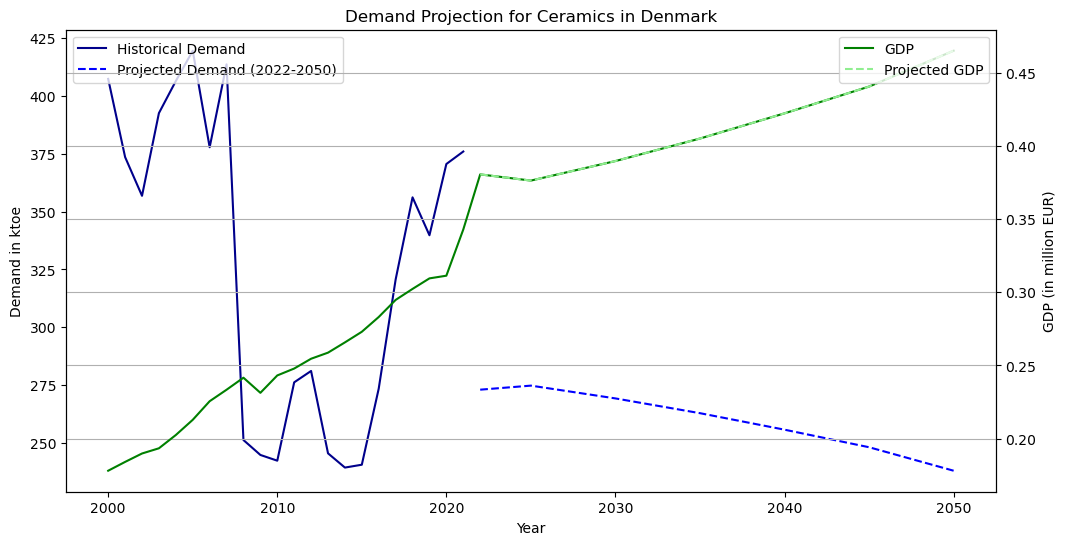

In [365]:
ceramics_prediction = linear_regression_single_sector(demand_df=historic_ceramics_demand_ktoe, sector_name = historic_ceramics_demand_ktoe.columns[0], historic_gdp=historic_gdp, projected_gdp=projected_gdp, gdp = gdp, region=gdp_region,unit = "ktoe", plot = True, save = False)

In [366]:

ktoe_to_GWh = 11.63

ceramics_prediction.rename(columns={'Predicted Demand': 'Predicted Demand [ktoe]'}, inplace=True)
ceramics_prediction["Predicted Demand [GWh]"] = ceramics_prediction["Predicted Demand [ktoe]"]*ktoe_to_GWh

In [367]:
ceramics_prediction

,Predicted Demand [ktoe],Predicted Demand [GWh]
Year,,
2022-01-01,273.013349,3175.145244
2023-01-01,273.597099,3181.934266
2024-01-01,274.180850,3188.723288
2025-01-01,274.764601,3195.512311
2026-01-01,273.658140,3182.644165
2027-01-01,272.551678,3169.776020
2028-01-01,271.445217,3156.907874
2029-01-01,270.338756,3144.039729
2030-01-01,269.232294,3131.171583


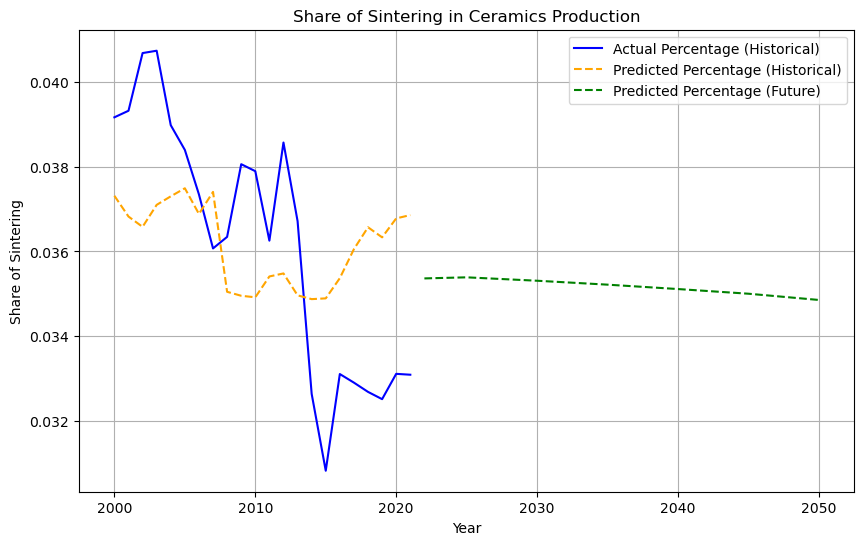

In [368]:
ceramics_projection_sintering_percentage = linear_regression_with_prediction(demand_sector_df=historic_ceramics_demand_ktoe,future_data_df=ceramics_prediction, column_name_LR="Share of Sintering", column_name_IV="Ceramics",column_name_IV_future= "Predicted Demand [ktoe]", graph_title = "Share of Sintering in Ceramics Production", save = False)

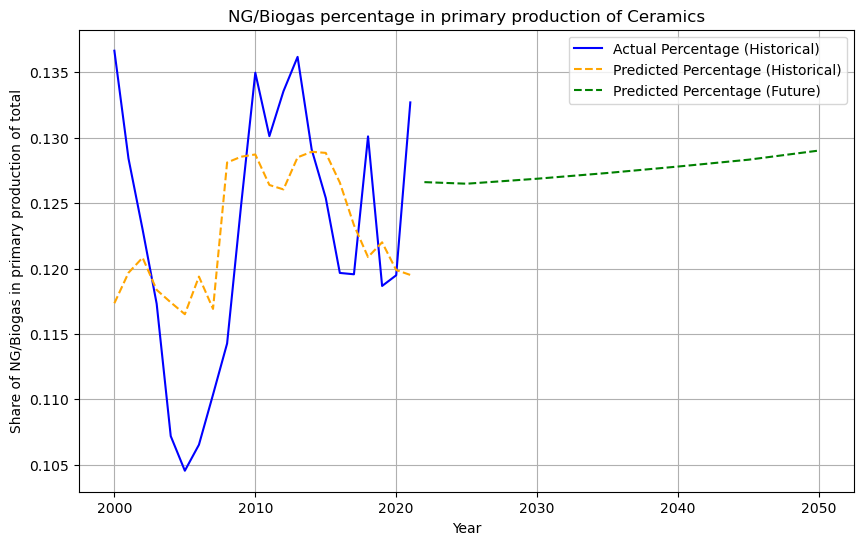

In [369]:
ceramics_projection_NG_biogas_percentage = linear_regression_with_prediction(demand_sector_df=historic_ceramics_demand_ktoe,future_data_df=ceramics_prediction, column_name_LR="Share of NG/Biogas in primary production of total", column_name_IV="Ceramics",column_name_IV_future= "Predicted Demand [ktoe]", graph_title = "NG/Biogas percentage in primary production of Ceramics", save = False)

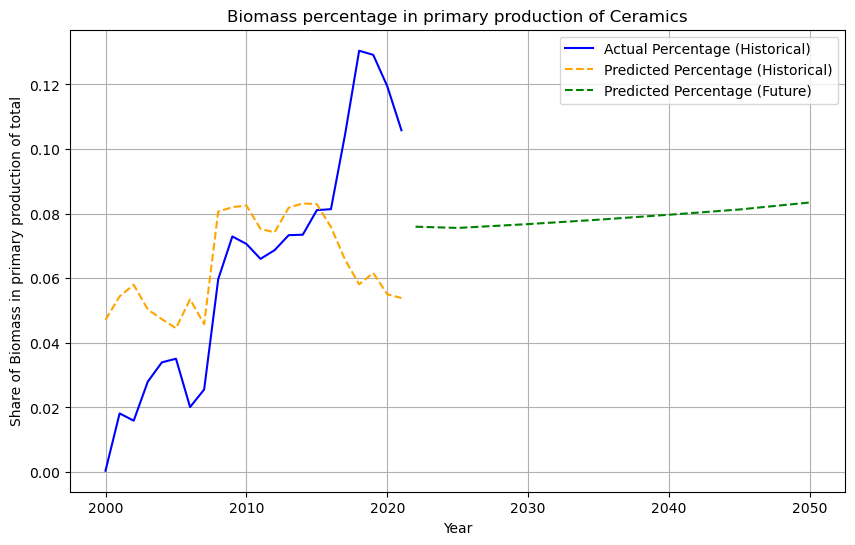

In [370]:
ceramics_projection_biomass_percentage = linear_regression_with_prediction(demand_sector_df=historic_ceramics_demand_ktoe,future_data_df=ceramics_prediction, column_name_LR="Share of Biomass in primary production of total", column_name_IV="Ceramics",column_name_IV_future= "Predicted Demand [ktoe]", graph_title = "Biomass percentage in primary production of Ceramics",  save = False)

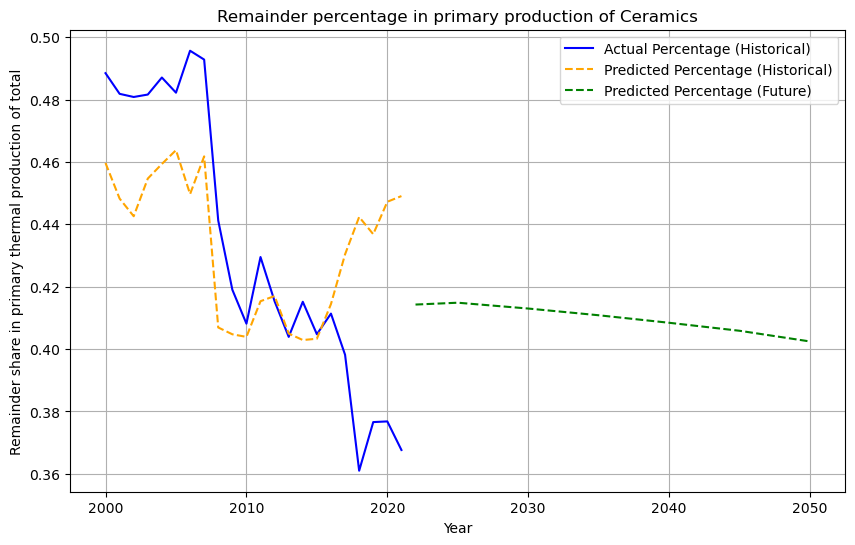

In [371]:
ceramics_projection_remainder_percentage = linear_regression_with_prediction(demand_sector_df=historic_ceramics_demand_ktoe,future_data_df=ceramics_prediction, column_name_LR="Remainder share in primary thermal production of total", column_name_IV="Ceramics",column_name_IV_future= "Predicted Demand [ktoe]",graph_title = "Remainder percentage in primary production of Ceramics", save = False)

In [372]:
ceramics_projection_sintering_percentage.rename(columns={'Predicted Percentage': 'Predicted Sintering Percentage'}, inplace=True)
ceramics_projection_NG_biogas_percentage.rename(columns={'Predicted Percentage': 'Predicted NG/H2 Percentage'}, inplace=True)
ceramics_projection_biomass_percentage.rename(columns={'Predicted Percentage': 'Predicted Biomass Percentage'}, inplace=True)
ceramics_projection_remainder_percentage.rename(columns={'Predicted Percentage': 'Predicted Remainder Percentage'}, inplace=True)


In [373]:
ceramics_projection_sintering_percentage["Predicted Sintering Percentage"]+ceramics_projection_NG_biogas_percentage["Predicted NG/H2 Percentage"]+ceramics_projection_biomass_percentage["Predicted Biomass Percentage"]+ceramics_projection_remainder_percentage["Predicted Remainder Percentage"]

Year
2000-01-01    0.661475
2001-01-01    0.659145
2002-01-01    0.657992
2003-01-01    0.660455
2004-01-01    0.661411
2005-01-01    0.662315
2006-01-01    0.659438
2007-01-01    0.661909
2008-01-01    0.650716
2009-01-01    0.650271
2010-01-01    0.650100
2011-01-01    0.652434
2012-01-01    0.652773
2013-01-01    0.650319
2014-01-01    0.649895
2015-01-01    0.649980
2016-01-01    0.652246
2017-01-01    0.655502
2018-01-01    0.657946
2019-01-01    0.656817
2020-01-01    0.658939
2021-01-01    0.659312
2022-01-01    0.652216
2023-01-01    0.652256
2024-01-01    0.652296
2025-01-01    0.652336
2026-01-01    0.652260
2027-01-01    0.652184
2028-01-01    0.652108
2029-01-01    0.652031
2030-01-01    0.651955
2031-01-01    0.651867
2032-01-01    0.651779
2033-01-01    0.651691
2034-01-01    0.651603
2035-01-01    0.651515
2036-01-01    0.651417
2037-01-01    0.651319
2038-01-01    0.651220
2039-01-01    0.651122
2040-01-01    0.651024
2041-01-01    0.650919
2042-01-01    0.650814
2043-0

In [374]:
ceramics_prediction["Predicted Sintering Demand [GWh]"] = ceramics_prediction["Predicted Demand [GWh]"]*ceramics_projection_sintering_percentage["Predicted Sintering Percentage"]
ceramics_prediction["Predicted NG/H2 Demand [GWh]"] = ceramics_prediction["Predicted Demand [GWh]"]*ceramics_projection_NG_biogas_percentage["Predicted NG/H2 Percentage"]
ceramics_prediction["Predicted Biomass Demand [GWh]"] = ceramics_prediction["Predicted Demand [GWh]"]*ceramics_projection_biomass_percentage["Predicted Biomass Percentage"]
ceramics_prediction["Predicted Remainder Demand [GWh]"] = ceramics_prediction["Predicted Demand [GWh]"]*ceramics_projection_remainder_percentage["Predicted Remainder Percentage"]

In [375]:
ceramics_prediction

,Predicted Demand [ktoe],Predicted Demand [GWh],Predicted Sintering Demand [GWh],Predicted NG/H2 Demand [GWh],Predicted Biomass Demand [GWh],Predicted Remainder Demand [GWh]
Year,,,,,,
2022-01-01,273.013349,3175.145244,112.290592,401.984851,241.171916,1315.431896
2023-01-01,273.597099,3181.934266,112.557608,402.716382,241.289030,1318.872175
2024-01-01,274.180850,3188.723288,112.824739,403.447366,241.404444,1322.315133
2025-01-01,274.764601,3195.512311,113.091985,404.177805,241.518157,1325.760768
2026-01-01,273.658140,3182.644165,112.585536,402.792843,241.301178,1319.232065
2027-01-01,272.551678,3169.776020,112.079499,401.405919,241.078089,1312.712985
2028-01-01,271.445217,3156.907874,111.573875,400.017033,240.848890,1306.203527
2029-01-01,270.338756,3144.039729,111.068664,398.626185,240.613581,1299.703691
2030-01-01,269.232294,3131.171583,110.563865,397.233374,240.372161,1293.213478


#### Glas
Difference between two processes: 
1. Containerglas in U shaped flame tray  
Percentage in energy consumption in Germany: 33-34%  
Electrification for small plant have a TRL 9, bigger plants <4  
Hydrogen fired burner, TRL <4
2. Continouus melting flat glass 
Percentage in energy consumption in Germany: 42-45%  
Electrification  <3  
Hydrogen fired burner, TRL <4

Workaround, assume that 44% of the demand in the melting process cannot be electriefied and therefore demand hydrogen after year 2040

In [376]:
historic_glass_demand_ktoe = NMM_cleaned.iloc[(NMM_cleaned[NMM_cleaned[NMM_column_name] == "Glass production"].index[0])]
historic_glass_demand_ktoe = transpose_uniformly(historic_glass_demand_ktoe)
historic_glass_demand_ktoe = historic_glass_demand_ktoe.to_frame()
historic_glass_demand_ktoe.columns=["Glass"]

C:\Users\flv.eco\AppData\Local\Temp\ipykernel_6236\2364290554.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_T.drop([NMM_column_name, "Code"], axis=0, inplace = True)


In [377]:
glass_thermal_melting = glass.loc[(glass[glass[NMM_column_name] == "Glass: Thermal melting tank"].index[0]):(glass[glass[NMM_column_name] == "Glass: Electric melting tank"].index[0]-1)]


In [378]:
glass_thermal_melting = transpose_uniformly(glass_thermal_melting)

In [379]:
historic_glass_demand_ktoe["Share of Thermal melting"] = glass_thermal_melting["Glass: Thermal melting tank"]/historic_glass_demand_ktoe["Glass"]


In [380]:
historic_glass_demand_ktoe

,Glass,Share of Thermal melting
Year,,
2000-01-01,39.214435,0.686984
2001-01-01,43.423085,0.683567
2002-01-01,38.550408,0.666497
2003-01-01,35.578317,0.680587
2004-01-01,34.687312,0.681786
2005-01-01,29.316512,0.66884
2006-01-01,46.599382,0.672869
2007-01-01,47.932445,0.679886
2008-01-01,47.335676,0.648562


c:\Users\flv.eco\AppData\Local\anaconda3\envs\ptx_markets\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


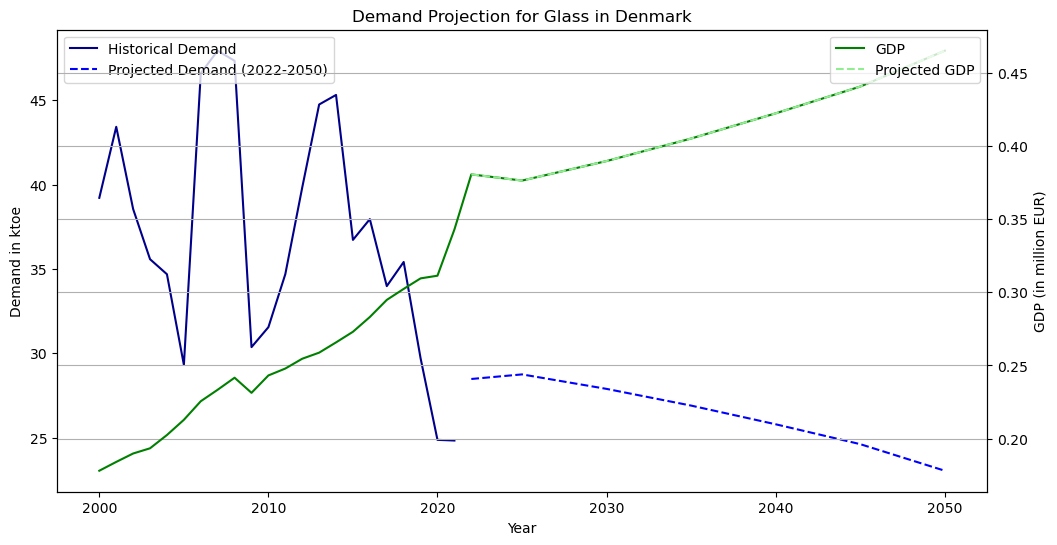

In [381]:
glass_prediction = linear_regression_single_sector(demand_df=historic_glass_demand_ktoe, sector_name = historic_glass_demand_ktoe.columns[0], historic_gdp=historic_gdp, projected_gdp=projected_gdp, gdp = gdp, region=gdp_region,unit = "ktoe", plot = True, save = False)
ktoe_to_GWh = 11.63

glass_prediction.rename(columns={'Predicted Demand': 'Predicted Demand [ktoe]'}, inplace=True)
glass_prediction["Predicted Demand [GWh]"] = glass_prediction["Predicted Demand [ktoe]"]*ktoe_to_GWh

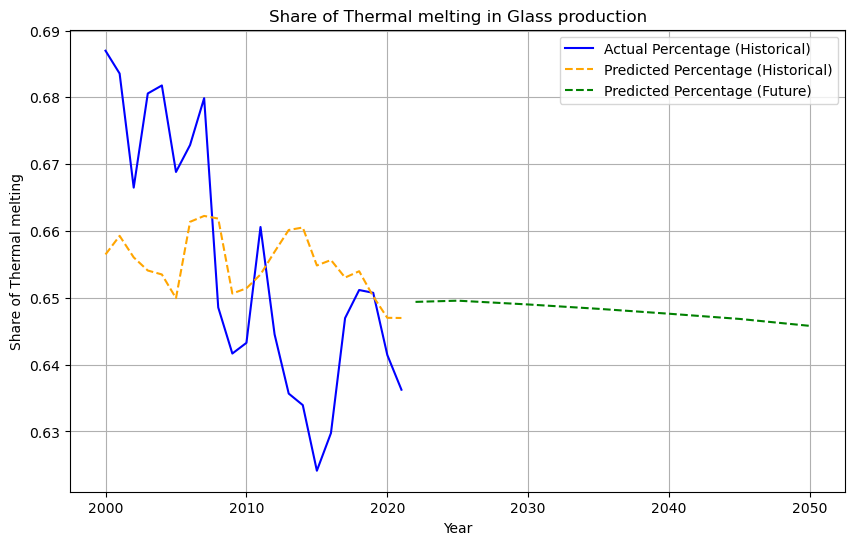

In [382]:
glass_projection_thermal_melting_percentage = linear_regression_with_prediction(demand_sector_df=historic_glass_demand_ktoe,future_data_df=glass_prediction, column_name_LR="Share of Thermal melting", column_name_IV="Glass",column_name_IV_future= "Predicted Demand [ktoe]",graph_title = "Share of Thermal melting in Glass production", save = False)

In [383]:
glass_projection_thermal_melting_percentage.rename(columns={'Predicted Percentage': 'Predicted Thermal Melting Percentage'}, inplace=True)


In [384]:
glass_prediction["Predicted NG/H2 Demand [GWh]"] = glass_prediction["Predicted Demand [GWh]"]*glass_projection_thermal_melting_percentage["Predicted Thermal Melting Percentage"]


In [385]:
glass_prediction

,Predicted Demand [ktoe],Predicted Demand [GWh],Predicted NG/H2 Demand [GWh]
Year,,,
2022-01-01,28.479621,331.217993,215.091042
2023-01-01,28.570207,332.271504,215.795089
2024-01-01,28.660792,333.325014,216.499261
2025-01-01,28.751378,334.378525,217.203560
2026-01-01,28.579679,332.381665,215.868715
2027-01-01,28.407980,330.384804,214.534323
2028-01-01,28.236281,328.387943,213.200384
2029-01-01,28.064581,326.391083,211.866899
2030-01-01,27.892882,324.394222,210.533868
